In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import matplotlib.animation as animation
import math
import os

from IPython.display import display, clear_output
from stable_fluid.fluid import Fluid
from matplotlib.collections import LineCollection
from noise import pnoise3  # pip install noise
from tqdm import tqdm
from datetime import datetime

#z, y, x순서임.

#근데 speed[0]은 x벡터의 크기, speed[1]은 y벡터의 크기, speed[2]는 z벡터의 크기 됨 주의.
#z, y, x
RESOLUTION = 360, 270, 270
DT = 1 #simulation sparsity.
FRAME_DT = 5
TOTAL_T = 200

INFLOW_DURATION = 200
INFLOW_TEMPERTURE = 1
INFLOW_RADIUS = 8

NUM_POLYLINE = 200
LEN_POLYLINE = 2500
NUM_POINTS = 2500

BUOYANCY_A = 0.05

Z_START = 6

SAVE_RANGE = (0, 1100)

FILE_NAME = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
os.makedirs("simulations/" + FILE_NAME, exist_ok=True)
print(FILE_NAME)

2025-10-07_22-53-33


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device: ", device)

fluid = Fluid(RESOLUTION, 'dye', 'heat', device = device)

center = torch.tensor((int(RESOLUTION[1] / 2), int(RESOLUTION[2] / 2)), device = device)

inflow_heat = torch.zeros(fluid.shape, device=device)
mask = torch.sum((fluid.indices[:-1, 0, :, :] - center[:, None, None])**2, dim=0) <= INFLOW_RADIUS ** 2
inflow_heat[Z_START][mask] = INFLOW_TEMPERTURE

inflow_dye = torch.zeros(fluid.shape, device=device)
inflow_dye[Z_START][mask] = 1


device:  cuda


In [3]:
def advect_polylines(vector_field: torch.Tensor, polylines: torch.Tensor, dt: float) -> torch.Tensor:
    """
    vector_field: (3, nz, ny, nx), vector_field[0] = u, [1] = v, [2] = w
    polylines: (NUM_POLYLINE, NUM_POINTS, 4), 마지막 좌표 w=1
    dt: float
    return: (NUM_POLYLINE, NUM_POINTS, 4), w는 그대로 유지
    """
    if polylines.numel() == 0:
        return polylines

    nz, ny, nx = vector_field.shape[1], vector_field.shape[2], vector_field.shape[3]

    # 실제 공간 좌표만 사용
    xyz = polylines[..., :3]  # (N,P,3)
    x = xyz[..., 0]
    y = xyz[..., 1]
    z = xyz[..., 2]

    # periodic index 적용
    x0 = torch.floor(x).long() % nx
    y0 = torch.floor(y).long() % ny
    z0 = torch.floor(z).long() % nz
    x1 = (x0 + 1) % nx
    y1 = (y0 + 1) % ny
    z1 = (z0 + 1) % nz

    sx = x - torch.floor(x)
    sy = y - torch.floor(y)
    sz = z - torch.floor(z)

    # ===== trilinear interpolation =====
    def trilerp(field):
        c000 = field[z0, y0, x0]
        c100 = field[z0, y0, x1]
        c010 = field[z0, y1, x0]
        c110 = field[z0, y1, x1]
        c001 = field[z1, y0, x0]
        c101 = field[z1, y0, x1]
        c011 = field[z1, y1, x0]
        c111 = field[z1, y1, x1]

        c00 = c000 * (1 - sx) + c100 * sx
        c01 = c001 * (1 - sx) + c101 * sx
        c10 = c010 * (1 - sx) + c110 * sx
        c11 = c011 * (1 - sx) + c111 * sx

        c0 = c00 * (1 - sy) + c10 * sy
        c1 = c01 * (1 - sy) + c11 * sy

        return c0 * (1 - sz) + c1 * sz

    u = trilerp(vector_field[0])
    v = trilerp(vector_field[1])
    w = trilerp(vector_field[2])

    # 좌표 업데이트
    new_x = x + u * dt
    new_y = y + v * dt
    new_z = z + w * dt

    # w 좌표 그대로 유지
    w_coord = polylines[..., 3:4]  # (N,P,1)

    return torch.cat([new_x.unsqueeze(-1), new_y.unsqueeze(-1), new_z.unsqueeze(-1), w_coord], dim=-1)



In [4]:
def redistribute_polyline_points(polylines: torch.Tensor, max_length: float) -> torch.Tensor:
    """
    polylines: (B, N, 4)  # 마지막 좌표 w=1
    return: (B, N, 4)
    
    각 polyline의 점 수를 유지하면서 점들의 위치를 일정 간격으로 재조정.
    w는 그대로 1로 유지됨.
    """
    assert polylines.shape[2] == 4, "Input must be (B,N,4)"
    
    num_polylines, NUM_POINTS, _ = polylines.shape
    device = polylines.device

    # 실제 공간 좌표만 사용 (x,y,z)
    xyz = polylines[:, :, :3]

    # segment 벡터 (B, N-1, 3)
    diffs = xyz[:, 1:, :] - xyz[:, :-1, :]

    # segment 길이 (B, N-1)
    dists = torch.linalg.norm(diffs, dim=2)

    # 누적 아크 길이 (B, N)
    cumdist = torch.cat(
        [torch.zeros((num_polylines, 1), device=device), torch.cumsum(dists, dim=1)],
        dim=1
    )

    total_len = cumdist[:, -1:]  # (B,1)

    new_len = torch.minimum(total_len, torch.tensor(max_length, device=device))

    # 새로운 점들의 위치 (등간격) (B, N)
    new_pos = torch.linspace(0, 1, NUM_POINTS, device=device).unsqueeze(0) * new_len

    # 각 new_pos가 속한 segment 찾기 (B, N)
    idx = torch.searchsorted(cumdist, new_pos, right=True) - 1
    idx = torch.clamp(idx, 0, NUM_POINTS - 2)

    # seg 시작점 (B, N, 3)
    seg_start = torch.gather(xyz, 1, idx.unsqueeze(-1).expand(-1, -1, 3))

    # seg 벡터 (B, N, 3)
    seg_vec = torch.gather(diffs, 1, idx.unsqueeze(-1).expand(-1, -1, 3))

    # seg 길이 (B, N)
    seg_len = torch.gather(dists, 1, idx)

    seg_offset = new_pos - torch.gather(cumdist, 1, idx)  # (B, N)
    ratio = (seg_offset / (seg_len + 1e-8)).unsqueeze(-1)  # (B, N, 1)

    # 보간 결과 (B, N, 3)
    resampled_xyz = seg_start + seg_vec * ratio

    # 마지막 좌표 w=1 추가
    w = torch.ones((num_polylines, NUM_POINTS, 1), device=device)
    resampled = torch.cat([resampled_xyz, w], dim=2)  # (B, N, 4)

    return resampled


In [5]:
def get_drawing_polylines(polylines):
    
    drawing_polylines = []
    res_tensor = torch.tensor((RESOLUTION[2], RESOLUTION[0]))  # (W,H) → 텐서로 변환
    for poly in polylines:
        polyline = []
        prev_div = None  # 이전 점이 속한 cell 기록
        
        for point in poly:
            point = point.cpu()
            
            # (x,y) 좌표 → 어떤 cell인지 계산
            div = (point // res_tensor).tolist()
            
            # polyline이 끊어져야 하는 경우
            if prev_div is not None and div != prev_div:
                if polyline:  # 지금까지 모인 점 저장
                    drawing_polylines.append(polyline)
                polyline = []
            
            # 현재 cell 내부 좌표 (잔여 좌표)
            local_point = (point % res_tensor).tolist()
            polyline.append(local_point)
            
            prev_div = div
        
        if polyline:  # 마지막 잔여 선분 처리
            drawing_polylines.append(polyline)
    return drawing_polylines

In [6]:
def rotate_and_project_volume(vol_torch, a, b, alpha, device='cpu'):
    """
    vol_torch: torch tensor of shape (nz, ny, nx)
    a, b: 회전축이 지나는 점 (x=a, y=b)
    alpha: 회전 각도 (라디안)
    device: 'cpu' or 'cuda'
    """

    # (1,1,nz,ny,nx) 형태로 변환
    if vol_torch.dim() == 3:
        vol = vol_torch.unsqueeze(0).unsqueeze(0).to(device)
    else:
        vol = vol_torch.to(device)

    nz, ny, nx = vol.shape[-3], vol.shape[-2], vol.shape[-1]

    # 회전 행렬 (z축 기준 회전)
    ca = np.cos(alpha)
    sa = np.sin(alpha)
    R = np.array([
        [ca, -sa, 0.],
        [sa,  ca, 0.],
        [0.,   0., 1.]
    ])

    # 원점을 (a,b)로 이동한 상태에서 회전시키기 위한 translation
    t = np.array([
        a - a * ca + b * sa,
        b - a * sa - b * ca,
        0.0
    ])

    # 4x4 변환 행렬
    M = np.eye(4)
    M[:3, :3] = R
    M[:3, 3] = t
    M_inv = np.linalg.inv(M)

    # 출력 격자 (z, y, x 순서)
    zz, yy, xx = np.meshgrid(
        np.arange(nz),
        np.arange(ny),
        np.arange(nx),
        indexing='ij'
    )
    pts = np.stack([xx.ravel(), yy.ravel(), zz.ravel()], axis=1)

    # 변환 적용 (homogeneous coords)
    ones = np.ones((pts.shape[0], 1))
    pts_h = np.concatenate([pts, ones], axis=1)
    src = (M_inv @ pts_h.T).T[:, :3]  # (N,3)

    # grid_sample용 정규화 [-1,1]
    src_x = 2.0 * (src[:, 0] / (nx - 1)) - 1.0
    src_y = 2.0 * (src[:, 1] / (ny - 1)) - 1.0
    src_z = 2.0 * (src[:, 2] / (nz - 1)) - 1.0

    grid = np.stack([src_x, src_y, src_z], axis=1)
    grid = grid.reshape((nz, ny, nx, 3))

    # torch grid로 변환
    grid_t = torch.from_numpy(grid).float().unsqueeze(0).to(device)  # (1, nz, ny, nx, 3)

    # grid_sample 적용
    out = F.grid_sample(
        vol,
        grid_t,
        mode='bilinear',
        padding_mode='zeros',
        align_corners=True
    )

    # (1,1,nz,ny,nx) -> (nz,ny,nx)
    rotated = out.squeeze(0).squeeze(0)

    # y축 방향으로 합산해 (z,x) 평면으로 투영
    projection = rotated.sum(dim=1)  # (nz, nx)

    return projection.cpu()
    
def rotate_and_project_polylines(polylines: torch.Tensor, a: float, b: float, alpha: float) -> torch.Tensor:
    """
    polylines: (B, N, 4)  # 마지막 좌표 w=1
    a, b: 회전축이 지나는 점 (x=a, y=b)
    alpha: 회전 각도 (라디안)

    return: (B, N, 2)  # (x,z) 평면
    """
    assert polylines.shape[2] == 4, "Input must be (B,N,4)"
    B, N, _ = polylines.shape
    device = polylines.device

    # 회전 행렬 (z축 기준)
    ca = torch.cos(torch.tensor(alpha, device=device))
    sa = torch.sin(torch.tensor(alpha, device=device))
    R = torch.tensor([
        [ca, -sa, 0.],
        [sa,  ca, 0.],
        [0.,  0., 1.]
    ], device=device)  # (3,3)

    # 원점 (a,b) 이동 적용: x-a, y-b, z 그대로
    xyz = polylines[:, :, :3]  # (B,N,3)
    xyz_shifted = xyz.clone()
    xyz_shifted[:, :, 0] -= a
    xyz_shifted[:, :, 1] -= b

    # batch-wise 회전
    rotated_xyz = torch.matmul(xyz_shifted, R.T)

    # 원점 복원
    rotated_xyz[:, :, 0] += a
    rotated_xyz[:, :, 1] += b

    # (x,z) 평면만 추출
    xz = rotated_xyz[:, :, [0, 2]]  # (B,N,2)

    return xz


In [7]:
'''
import perlin_numpy as perlin

shape = RESOLUTION
scale = 10.0

# 3D perlin noise, 3 성분 별로 독립적 생성
vel = torch.stack([
    torch.tensor(perlin.generate_perlin_noise_3d(shape, (int(scale), int(scale), int(scale))),
                 dtype=torch.float32, device=device),
    torch.tensor(perlin.generate_perlin_noise_3d(shape, (int(scale), int(scale), int(scale))),
                 dtype=torch.float32, device=device),
    torch.tensor(perlin.generate_perlin_noise_3d(shape, (int(scale), int(scale), int(scale))),
                 dtype=torch.float32, device=device)
], dim=0)  # shape: (3, nz, ny, nx)
print(vel.shape)
#torch.save(vel, "initial_vel.pt")
'''

'\nimport perlin_numpy as perlin\n\nshape = RESOLUTION\nscale = 10.0\n\n# 3D perlin noise, 3 성분 별로 독립적 생성\nvel = torch.stack([\n    torch.tensor(perlin.generate_perlin_noise_3d(shape, (int(scale), int(scale), int(scale))),\n                 dtype=torch.float32, device=device),\n    torch.tensor(perlin.generate_perlin_noise_3d(shape, (int(scale), int(scale), int(scale))),\n                 dtype=torch.float32, device=device),\n    torch.tensor(perlin.generate_perlin_noise_3d(shape, (int(scale), int(scale), int(scale))),\n                 dtype=torch.float32, device=device)\n], dim=0)  # shape: (3, nz, ny, nx)\nprint(vel.shape)\n#torch.save(vel, "initial_vel.pt")\n'

In [8]:
vel = torch.load("initial_vel.pt", weights_only=False)

In [9]:
fluid.velocity = vel * 0.4
for i in tqdm(range(10)):
    fluid.step(dt=DT, eps_conf=0.04)

100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


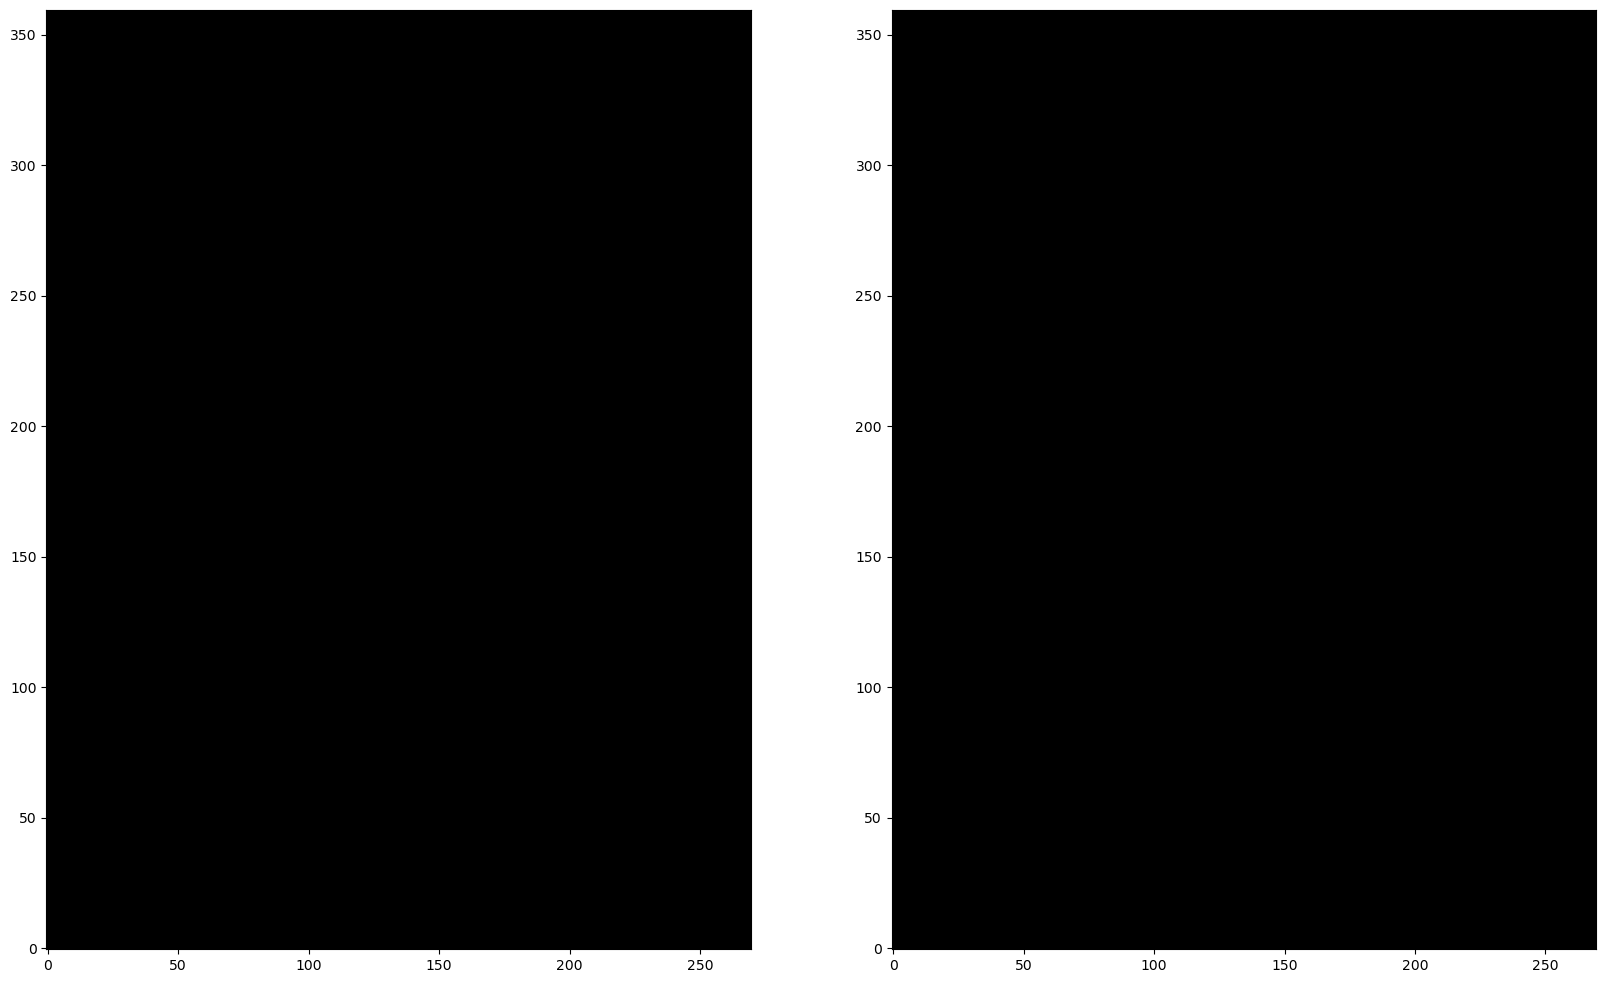

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))  # 1행 2열
im1 = axes[0].imshow(np.zeros(RESOLUTION[:2]), cmap='gray', vmin=0, vmax=1, origin="lower")
im2 = axes[1].imshow(np.zeros(RESOLUTION[:2]), cmap='gray', vmin=0, vmax=1, origin="lower")

line_segments1 = LineCollection([], colors='gray', linewidths=0.2)

axes[1].add_collection(line_segments1)

inflow_h_mask = (inflow_heat == 0)
inflow_d_mask = (inflow_dye == 0)

angles = torch.linspace(0, 2*math.pi, NUM_POLYLINE+1, device=device)[:-1]  # (NUM_POLYLINE,)

# 원형 좌표
circle_points = torch.stack((torch.cos(angles), torch.sin(angles)), dim=1) * (INFLOW_RADIUS - 1) + center 
z_coords = torch.full((NUM_POLYLINE, 1), Z_START, device=device)  # (NUM_POLYLINE, 1)
w = torch.full((NUM_POLYLINE, 1), 1, device=device)  # (NUM_POLYLINE, 1)
circle_points_3d = torch.cat((circle_points, z_coords, w), dim=1).unsqueeze(1)  # (NUM_POLYLINE, 1, 4)
polylines = circle_points_3d.clone().repeat(1, NUM_POINTS, 1)

t = 0

def update(frame):
    global t, polylines, inflow_h_mask, inflow_d_mask
    for i in range(int(FRAME_DT / DT)):

        if(INFLOW_DURATION > t):
            fluid.heat = torch.where(inflow_h_mask, fluid.heat, inflow_heat)
            #fluid.velocity[2][inflow_h_mask] = 50
            fluid.dye = torch.where(inflow_d_mask, fluid.dye, inflow_dye)
    
        ambient = torch.mean(fluid.heat)  # 혹은 상수 0
        dT = fluid.heat - ambient
        dv = BUOYANCY_A * dT * DT
        fluid.velocity[2] += dv
        
        # 열 에너지 소모 (운동에너지로 전환)
        dEk = 0.5 * dv**2   # pointwise kinetic energy 증가
        #fluid.heat = torch.clamp(fluid.heat - dEk, min=0.0)
        fluid.step(dt=DT, eps_conf=0)
    
        
        polylines[:, 1:, :] = advect_polylines(fluid.velocity, polylines[:, 1:, :], DT)
        polylines = redistribute_polyline_points(polylines, LEN_POLYLINE)
        t += DT

    
    dye_cpu = rotate_and_project_volume(fluid.dye, center[0].cpu(), center[1].cpu(), 0)
    dye_cpu /= dye_cpu.max()
    im1.set_data(dye_cpu)
    
    projected_polylines = rotate_and_project_polylines(polylines, center[0].cpu(), center[1].cpu(), 0)
    drawing_polylines = get_drawing_polylines(projected_polylines)
    line_segments1.set_segments(drawing_polylines)
    
    clear_output(wait=True)
    display(fig)
    
    height, _, width = RESOLUTION  # 이미지 크기
    if not hasattr(update, "time_text"):
        update.time_text = axes[1].text(
            width - 5, 5,  # x=가로 끝-여유, y=밑에서 약간 위
            "", color="white", fontsize=12,
            ha="right", va="bottom", backgroundcolor="black"
        )
    
    update.time_text.set_text(f"{t:.2f} / {TOTAL_T}")

    if(t > SAVE_RANGE[0] and t < SAVE_RANGE[1]):
        torch.save(polylines, "simulations/" + FILE_NAME + "/" + str(t) + ".pt")

    return im1, im2, line_segments1


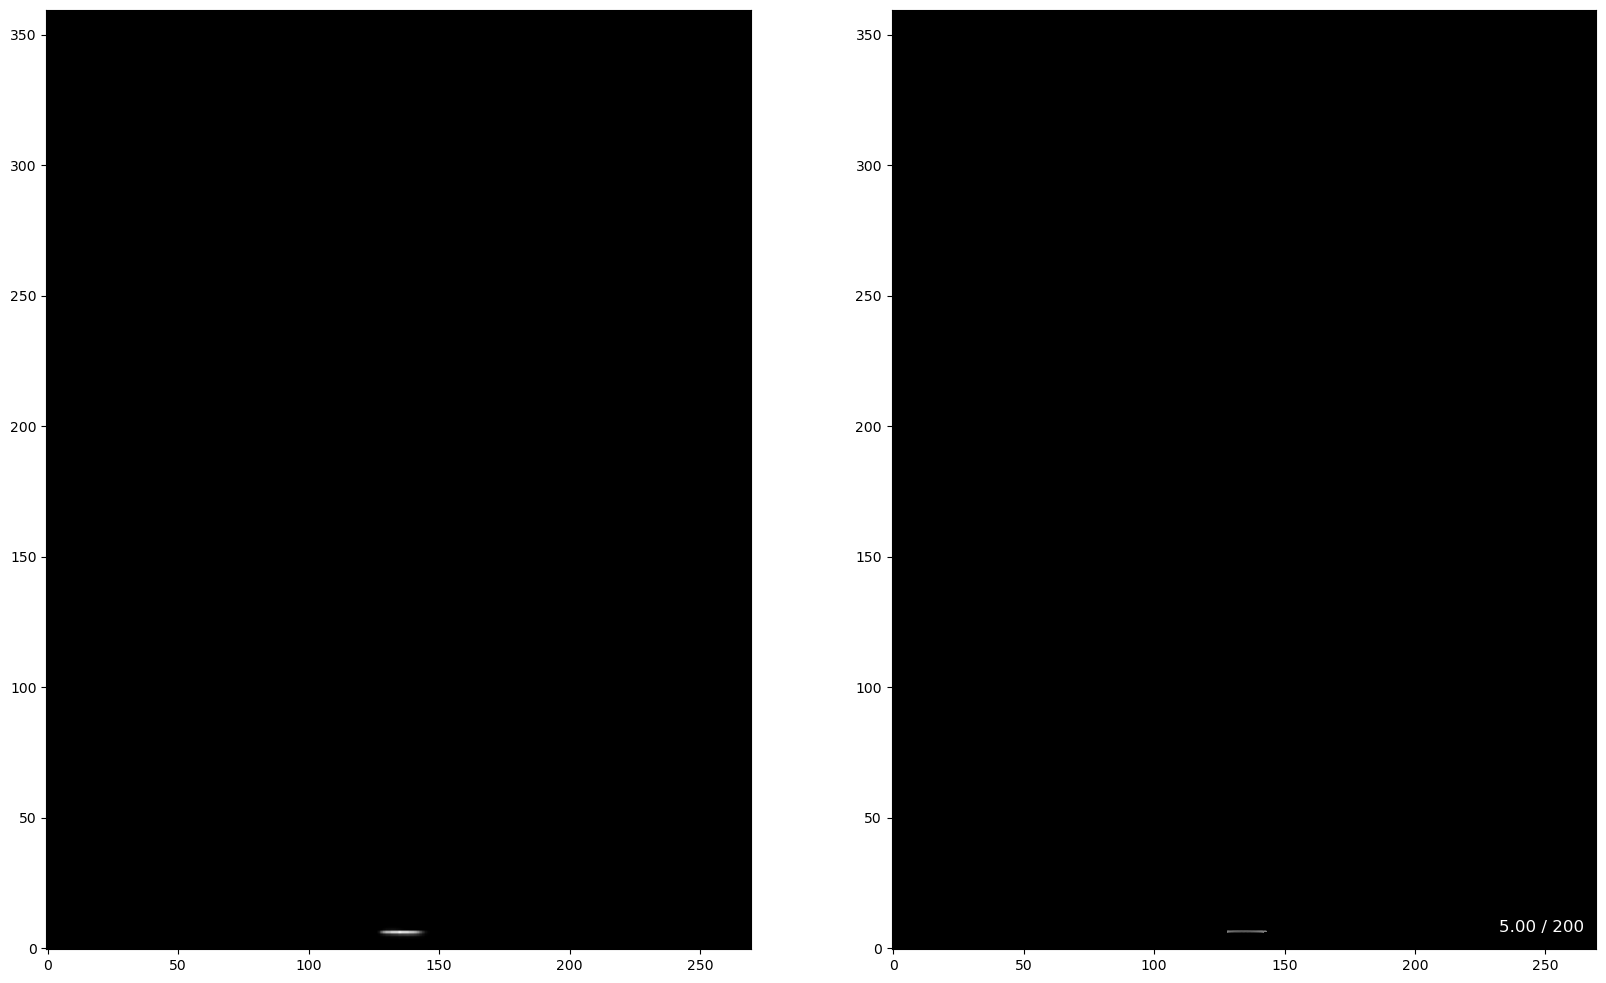

In [11]:
ani = animation.FuncAnimation(fig, update, frames=int(TOTAL_T / FRAME_DT), interval=50, blit=True)

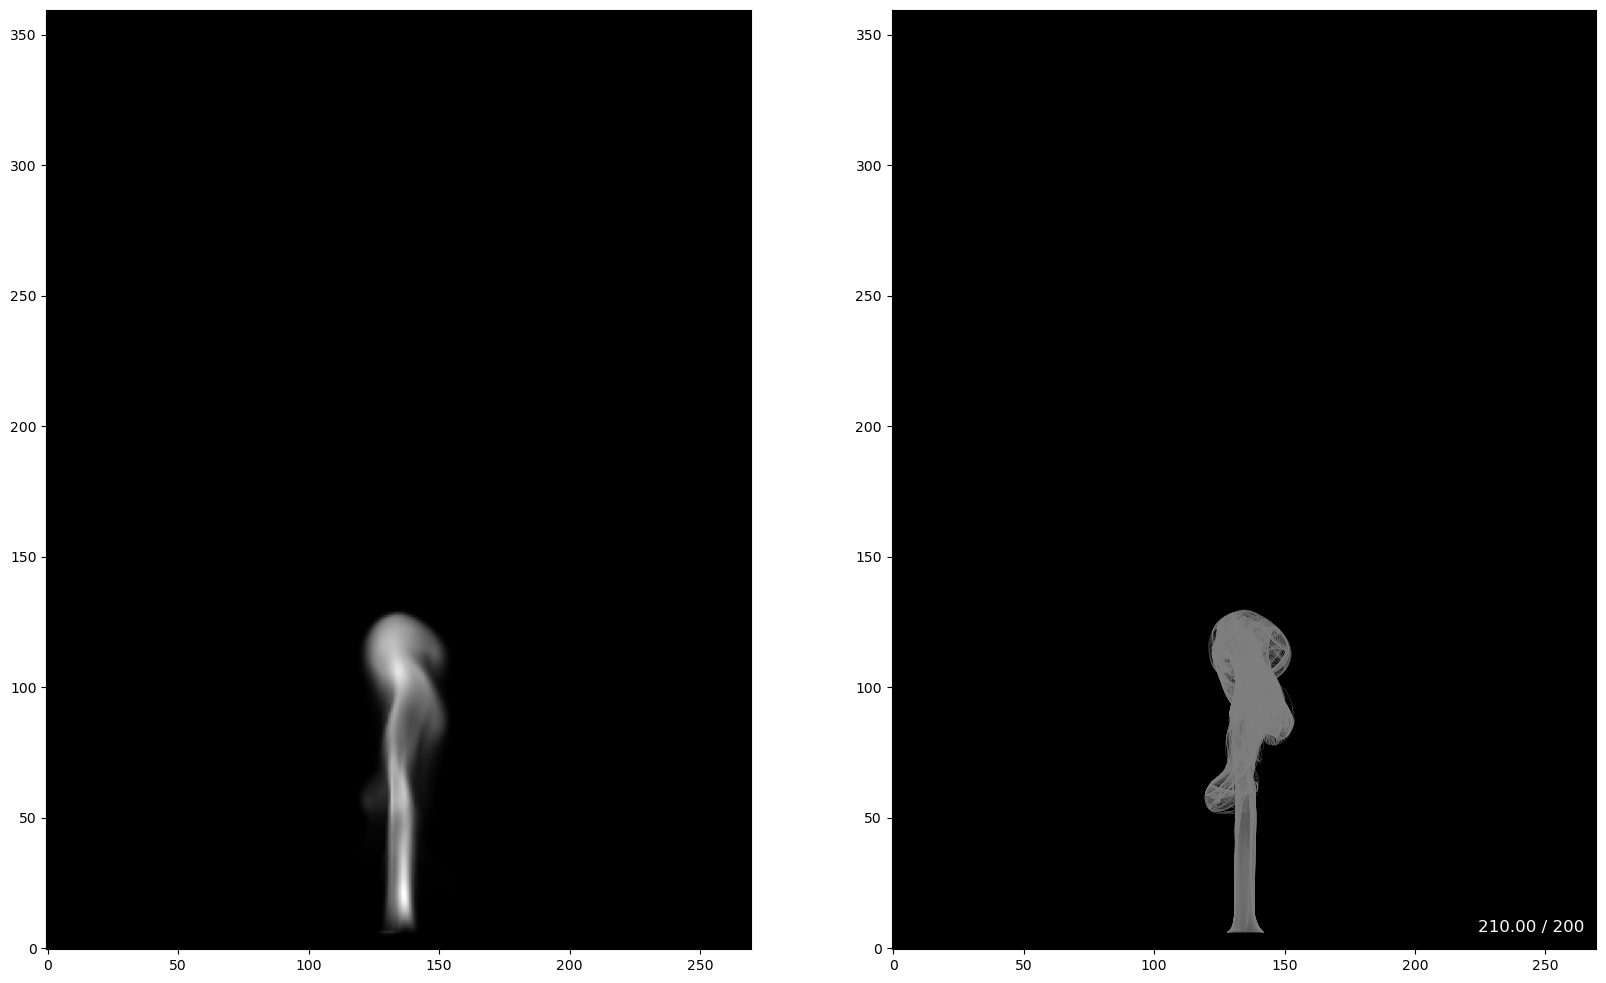

In [12]:
ani.save("simulations/" + FILE_NAME + "/video.mp4", writer=animation.FFMpegWriter(fps=25))